In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.optimize import minimize
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install emd
import emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [4]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

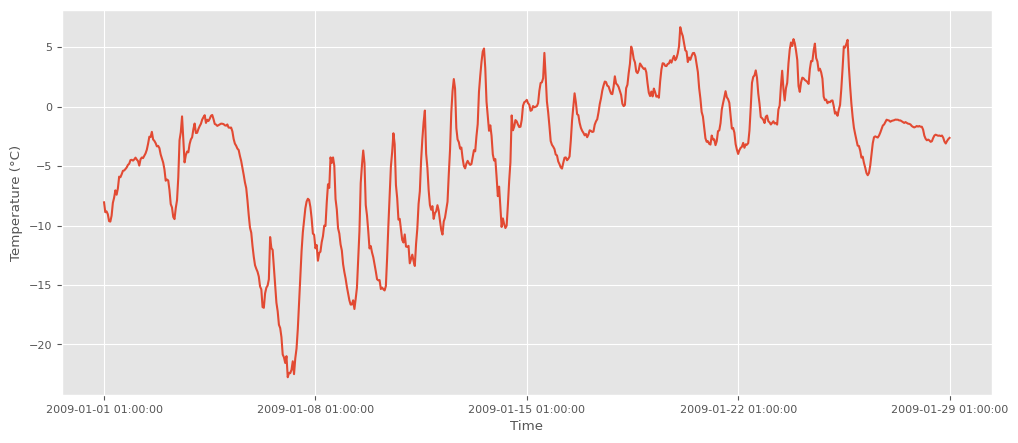

In [5]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

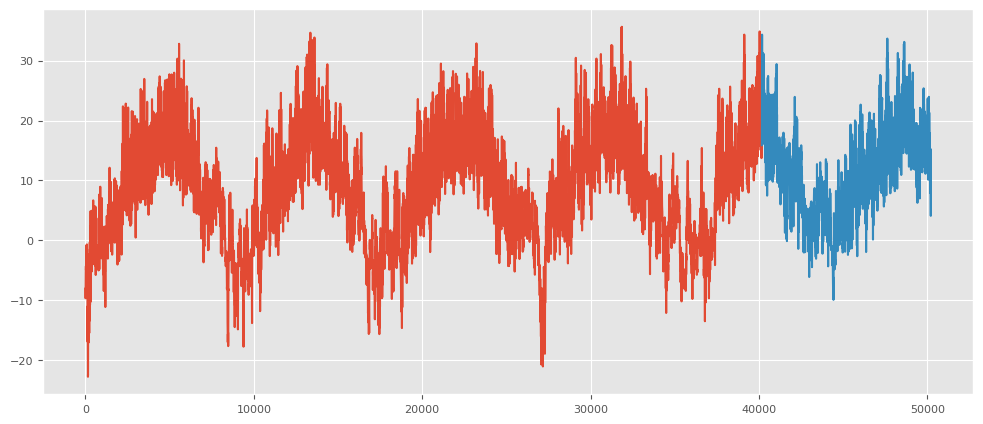

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

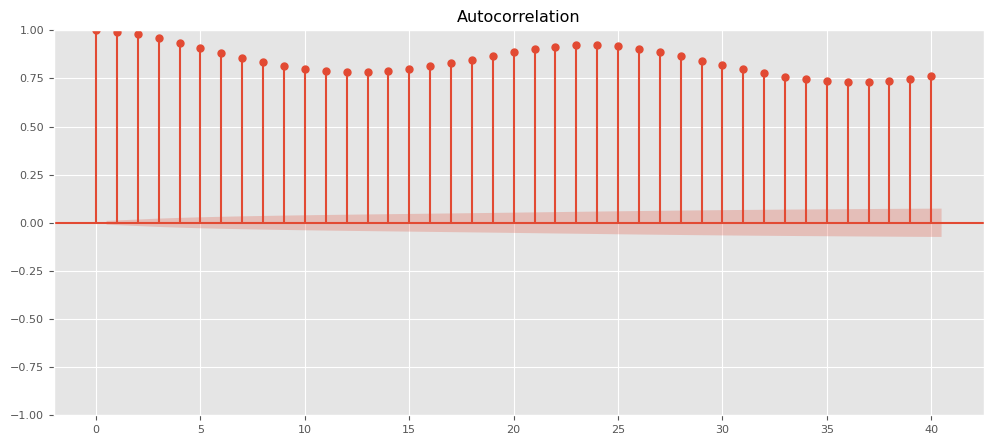

<Figure size 1200x500 with 0 Axes>

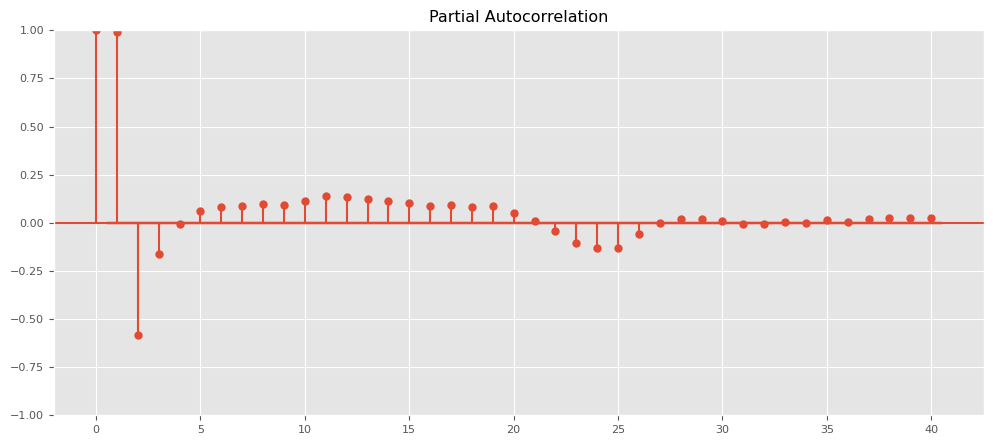

In [7]:
plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

# EEMD

<Axes: xlabel='Time (samples)'>

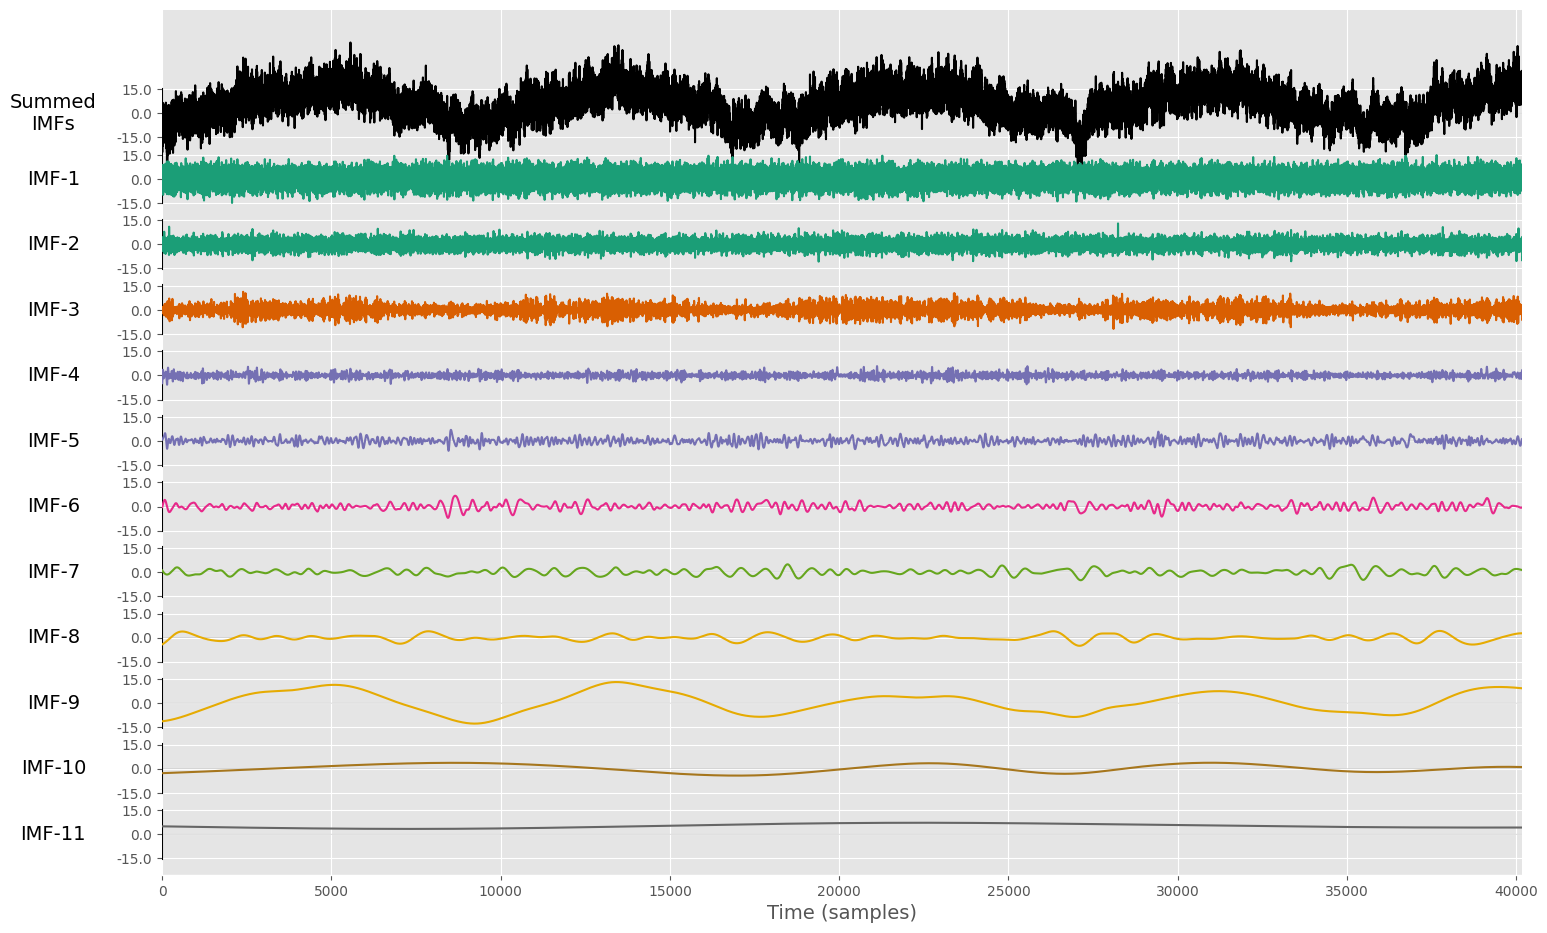

In [9]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [10]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,6.025389,0.717902,-0.265624,-4.828028,0.760994,-0.326343,1.074387,-4.212393,-11.291406,-2.784889,4.921395
1,7.003779,0.492198,-0.500923,-4.606012,0.769022,-0.241819,1.040619,-4.201708,-11.289038,-2.784115,4.921049
2,7.616438,-0.924564,-0.425406,-4.290802,0.781027,-0.157050,1.007001,-4.190943,-11.286659,-2.783341,4.920703
3,-6.705717,-1.923633,-0.128094,-3.895449,0.796784,-0.072080,0.973534,-4.180100,-11.284271,-2.782568,4.920357
4,-3.661172,-0.507476,0.279675,-3.434717,0.816070,0.013045,0.940221,-4.169178,-11.281874,-2.781794,4.920012
...,...,...,...,...,...,...,...,...,...,...,...
40174,0.774959,-1.338832,-4.429714,3.020729,1.316671,-0.586237,1.301645,2.698469,9.269043,1.045785,4.183614
40175,-4.828161,-6.446687,-5.408389,3.093972,1.307905,-0.575562,1.297397,2.698169,9.266869,1.045297,4.183651
40176,9.172065,-9.732947,-6.077346,3.148160,1.289472,-0.564565,1.293184,2.697844,9.264692,1.044807,4.183688
40177,-0.616051,-9.992560,-6.336096,3.183694,1.261618,-0.553249,1.289007,2.697496,9.262513,1.044316,4.183725


In [11]:
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [12]:
lstm_1 = 64
dropout = 0.2
lstm_2 = 32
dense_1 = 16
dense_2 = 1

epochs = 8
test_length = len(test)

In [13]:
# IMF 1
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

model1 = Sequential()
model1.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dropout(dropout))
model1.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model1.add(Dense(dense_1, activation='relu'))
model1.add(Dense(dense_2))
model1.compile(optimizer='adam', loss='mse')
model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=epochs, verbose=0)
imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# IMF 2
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

model2 = Sequential()
model2.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dropout(dropout))
model2.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model2.add(Dense(dense_1, activation='relu'))
model2.add(Dense(dense_2))
model2.compile(optimizer='adam', loss='mse')
model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=epochs, verbose=0)
imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

model3 = Sequential()
model3.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dropout(dropout))
model3.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model3.add(Dense(dense_1, activation='relu'))
model3.add(Dense(dense_2))
model3.compile(optimizer='adam', loss='mse')
model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=epochs, verbose=0)
imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# IMF 4
imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

model4 = Sequential()
model4.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
model4.add(Dropout(dropout))
model4.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model4.add(Dense(dense_1, activation='relu'))
model4.add(Dense(dense_2))
model4.compile(optimizer='adam', loss='mse')
model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=epochs, verbose=0)
imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# IMF 5
imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

model5 = Sequential()
model5.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
model5.add(Dropout(dropout))
model5.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model5.add(Dense(dense_1, activation='relu'))
model5.add(Dense(dense_2))
model5.compile(optimizer='adam', loss='mse')
model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=0)
imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [14]:
imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

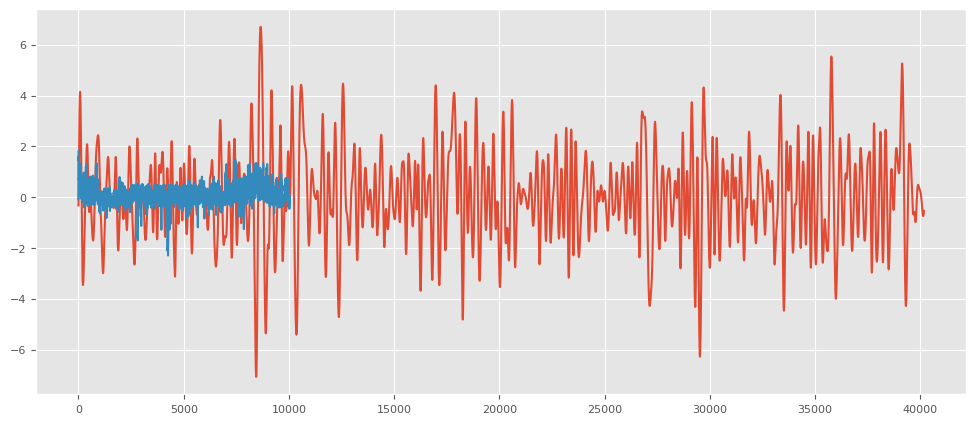

In [15]:
# plot imf10 test values vs predited values
plt.plot(imf_eemd_df['imf_eemd_6'])
plt.plot(imf6_eemd_SVR_fc)
plt.show()

In [16]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)

In [17]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
                imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc, imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc], axis = 0)

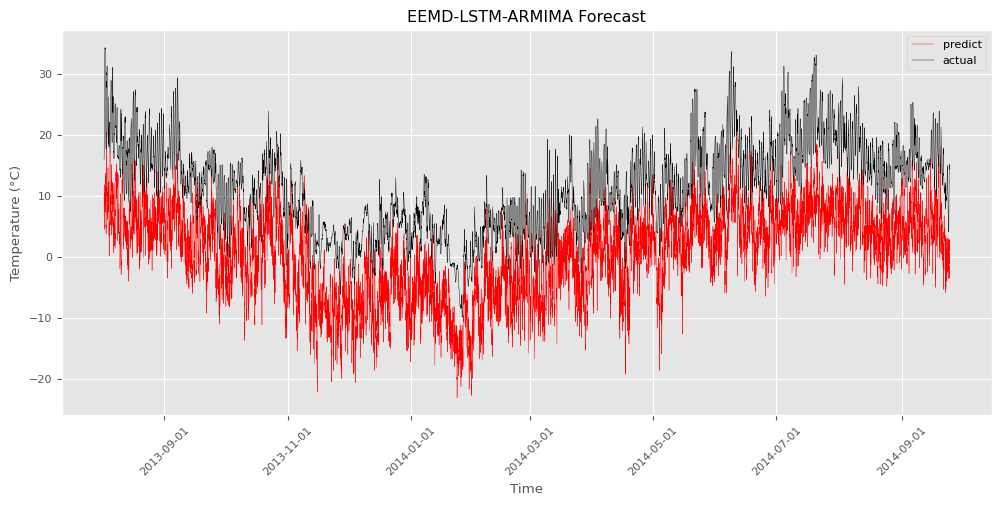

In [18]:
target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-LSTM-ARMIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

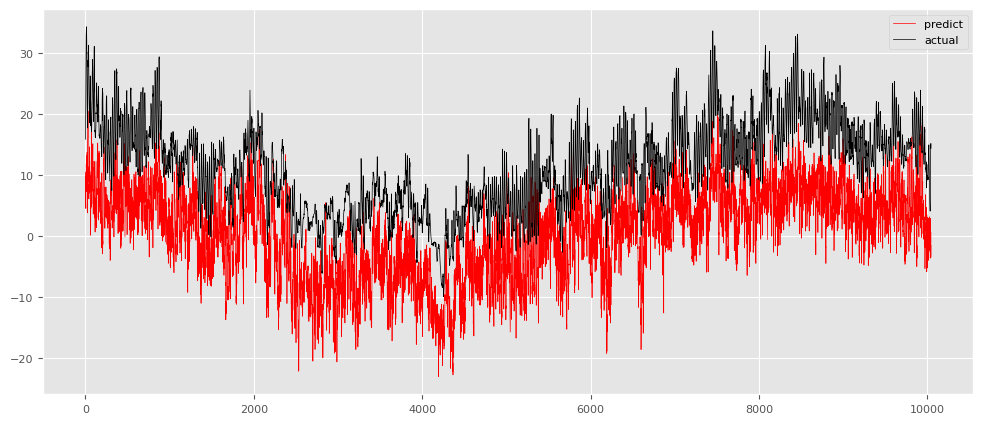

In [19]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [20]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 140.6964354263784 
MAE = 10.899757933299691 
MAPE = 8494890197774.102


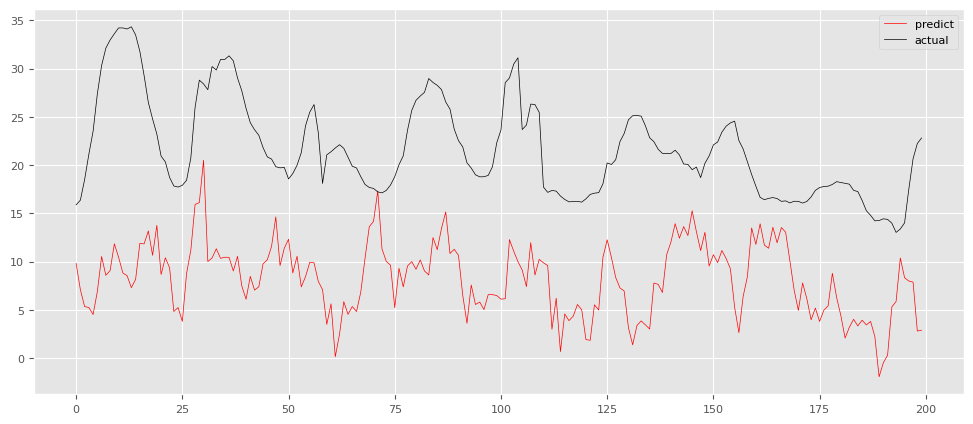

MSE = 140.6964354263784 
MAE = 10.899757933299691 
MAPE = 8494890197774.102


In [21]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [22]:
imf1_eemd_lstm_fc_train = model1.predict(imf1_eemd_lstm_X).reshape(-1, 1)
imf1_eemd_lstm_fc_train = scaler1.inverse_transform(imf1_eemd_lstm_fc_train)

imf2_eemd_lstm_fc_train = model2.predict(imf2_eemd_lstm_X).reshape(-1, 1)
imf2_eemd_lstm_fc_train = scaler2.inverse_transform(imf2_eemd_lstm_fc_train)

imf3_eemd_lstm_fc_train = model3.predict(imf3_eemd_lstm_X).reshape(-1, 1)
imf3_eemd_lstm_fc_train = scaler3.inverse_transform(imf3_eemd_lstm_fc_train)

imf4_eemd_lstm_fc_train = model4.predict(imf4_eemd_lstm_X).reshape(-1, 1)
imf4_eemd_lstm_fc_train = scaler4.inverse_transform(imf4_eemd_lstm_fc_train)

imf5_eemd_lstm_fc_train = model5.predict(imf5_eemd_lstm_X).reshape(-1, 1)
imf5_eemd_lstm_fc_train = scaler5.inverse_transform(imf5_eemd_lstm_fc_train)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [23]:
imf6_eemd_SVR_fc_train = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc_train = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc_train = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc_train = imf9_eemd_SVR.predict(np.array(df_train))
imf10_eemd_SVR_fc_train = imf10_eemd_SVR.predict(np.array(df_train))

In [24]:
imf1_eemd_lstm_fc_train_train = imf1_eemd_lstm_fc_train.reshape(-1)
imf2_eemd_lstm_fc_train_train = imf2_eemd_lstm_fc_train.reshape(-1)
imf3_eemd_lstm_fc_train_train = imf3_eemd_lstm_fc_train.reshape(-1)
imf4_eemd_lstm_fc_train_train = imf4_eemd_lstm_fc_train.reshape(-1)
imf5_eemd_lstm_fc_train_train = imf5_eemd_lstm_fc_train.reshape(-1)

In [25]:
# elimina el primer registro en cada imf svr
imf6_eemd_SVR_fc_train_6 = imf6_eemd_SVR_fc_train[1:]
imf7_eemd_SVR_fc_train_7 = imf7_eemd_SVR_fc_train[1:]
imf8_eemd_SVR_fc_train_8 = imf8_eemd_SVR_fc_train[1:]
imf9_eemd_SVR_fc_train_9 = imf9_eemd_SVR_fc_train[1:]
imf10_eemd_SVR_fc_train_10 = imf10_eemd_SVR_fc_train[1:]

In [26]:
imf_eemd_fc_train = np.sum([imf1_eemd_lstm_fc_train_train, imf2_eemd_lstm_fc_train_train, imf3_eemd_lstm_fc_train_train,
                imf4_eemd_lstm_fc_train_train, imf5_eemd_lstm_fc_train_train, imf6_eemd_SVR_fc_train_6,
                imf7_eemd_SVR_fc_train_7, imf8_eemd_SVR_fc_train_8, imf9_eemd_SVR_fc_train_9, imf10_eemd_SVR_fc_train_10], axis = 0)

In [27]:
# elimina el primer registro de train
train = train[1:]

In [28]:
def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 15.117699
         Iterations: 45
         Function evaluations: 91
[10.8154789]


In [29]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 22.396391946408972 
MAE = 3.75605301753931 
MAPE = 2608313530575.8735


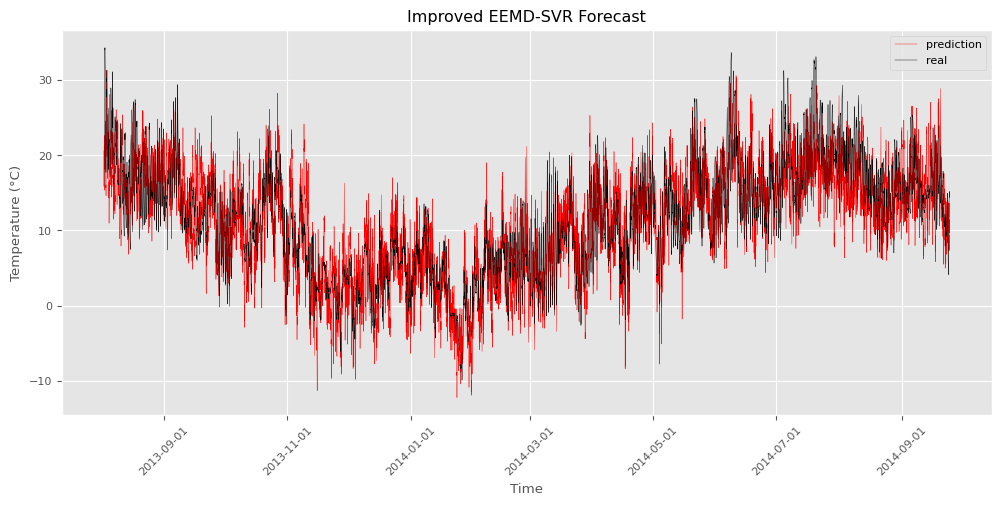

In [30]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

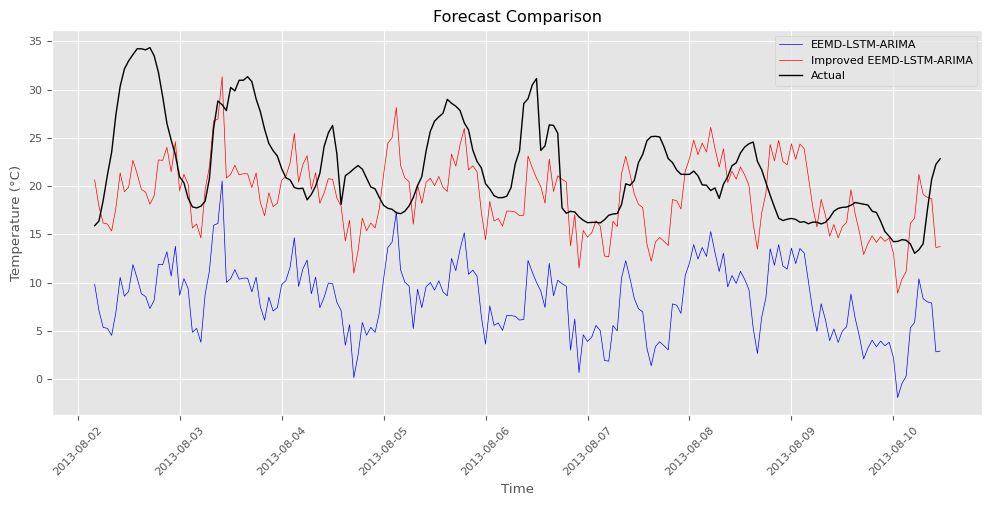

In [31]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-LSTM-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-LSTM-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()